/home/tung6100/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_1488431/4094258428.py:109: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


/tmp/ipykernel_1488431/4094258428.py:150: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.title('%f' % d[i])
/tmp/ipykernel_1488431/4094258428.py:148: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/tmp/ipykernel_1488431/4094258428.py:185: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10


d = 
  (columns 0 through 7)
    -0.02133    -0.02647    -0.02647    -0.06109    -3.23184    -3.33172    -3.34554    -3.35897
  (columns 8 through 9)
    -5.45044    -5.52431


/tmp/ipykernel_1488431/4094258428.py:202: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.title('%f' % d[i])
/tmp/ipykernel_1488431/4094258428.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.title('lambda = %f' % d[i])


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


/tmp/ipykernel_1488431/4094258428.py:316: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10
/home/tung6100/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4186: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


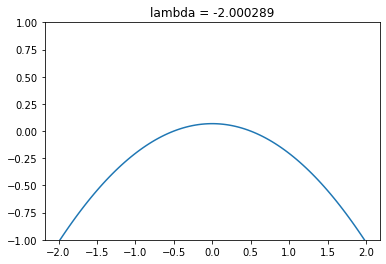

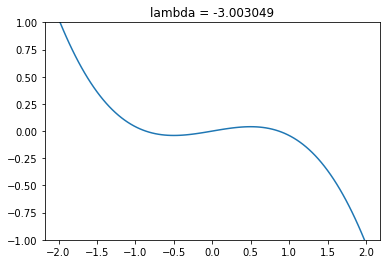

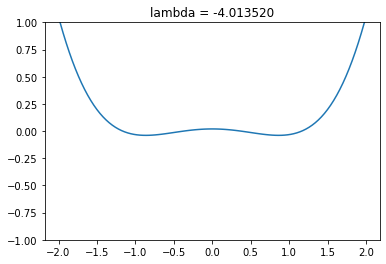

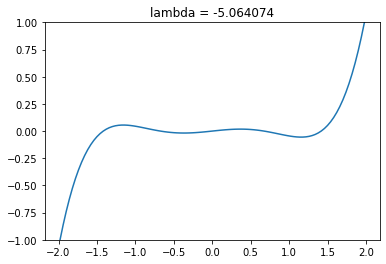

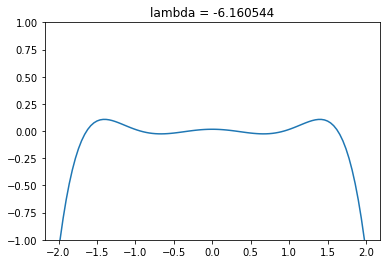

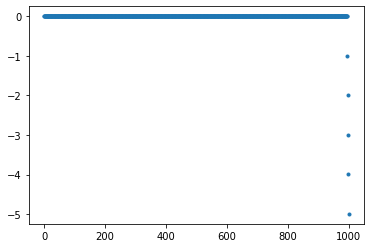

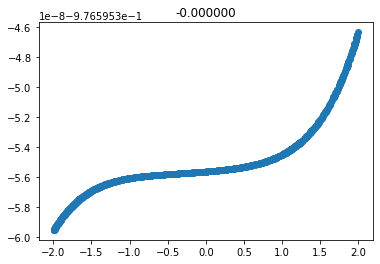

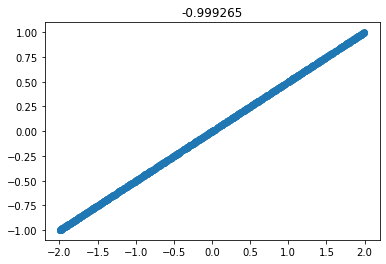

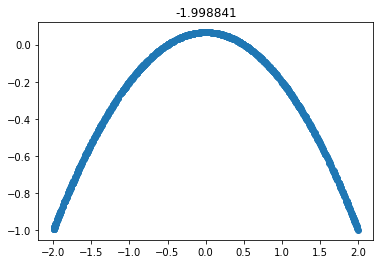

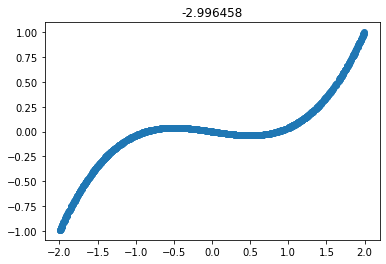

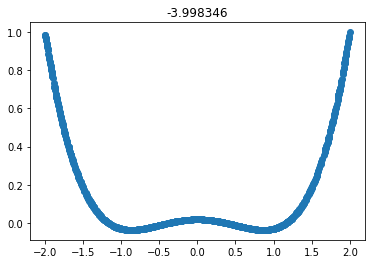

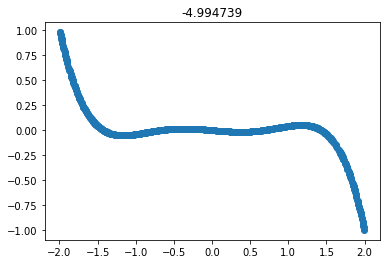

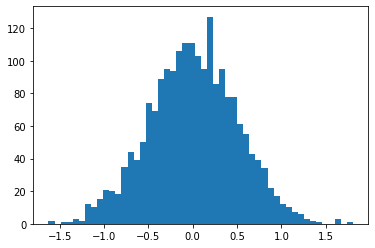

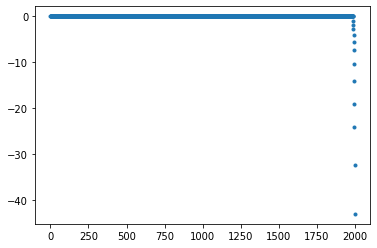

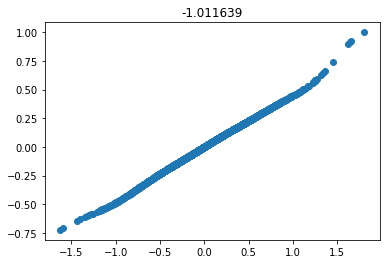

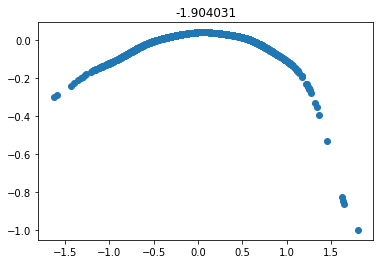

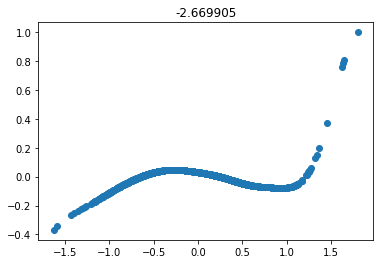

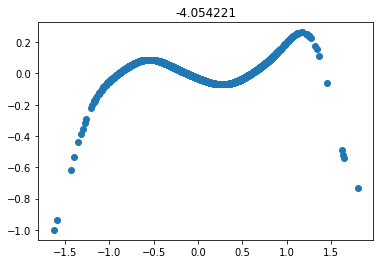

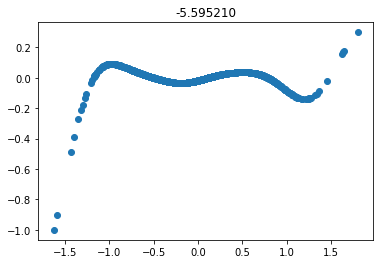

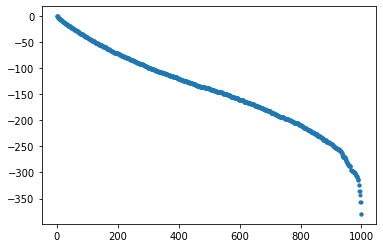

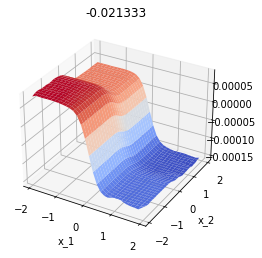

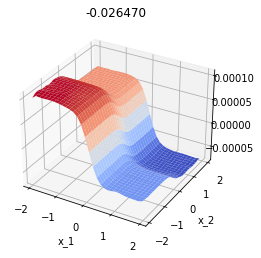

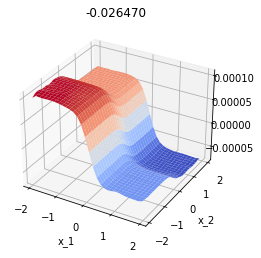

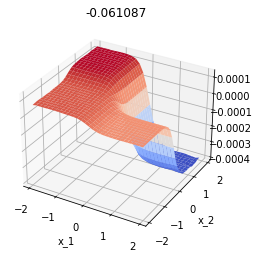

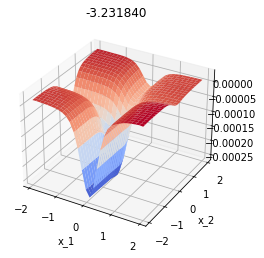

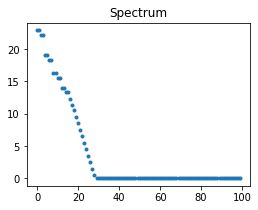

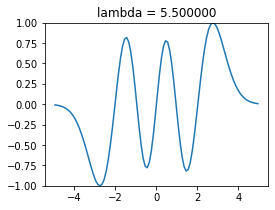

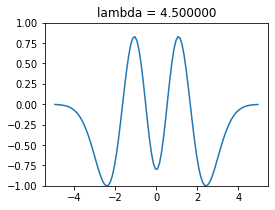

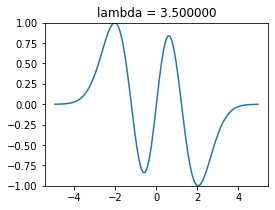

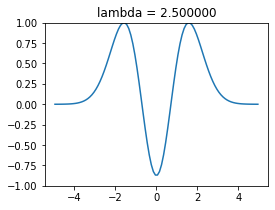

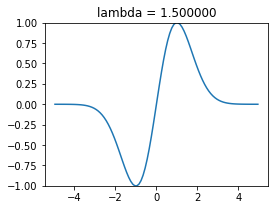

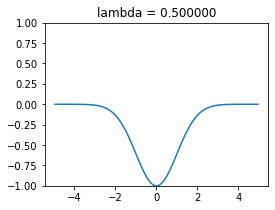

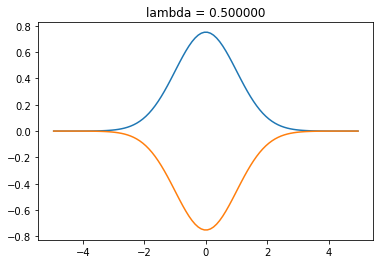

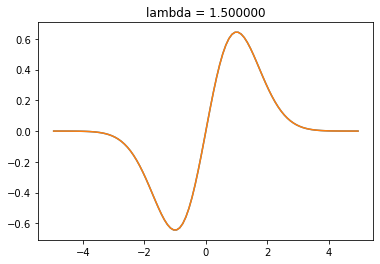

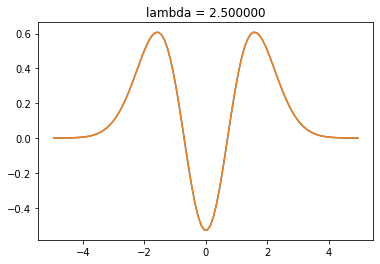

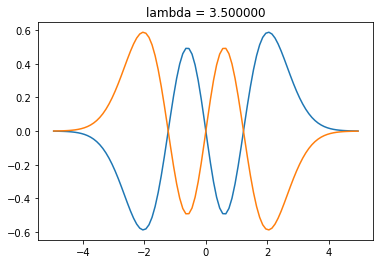

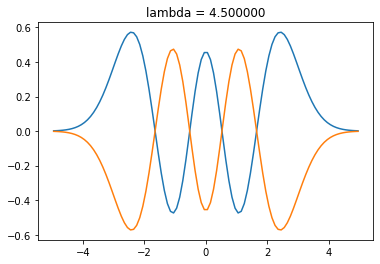

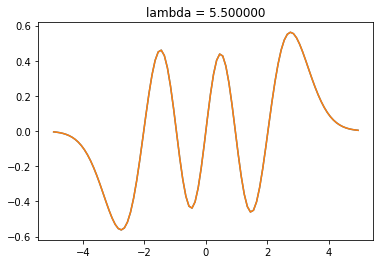

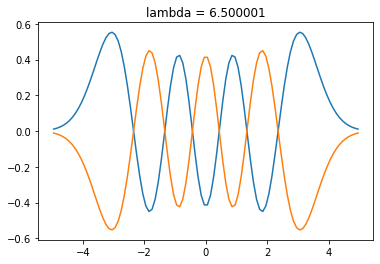

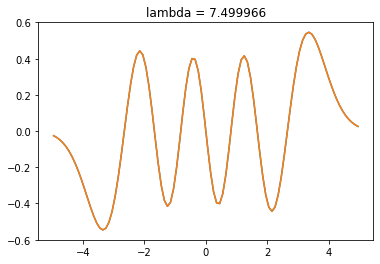

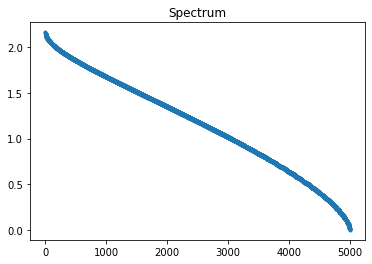

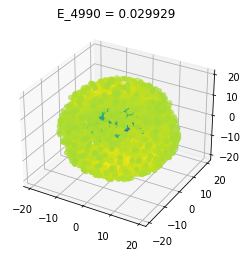

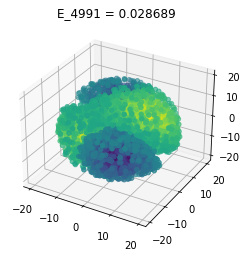

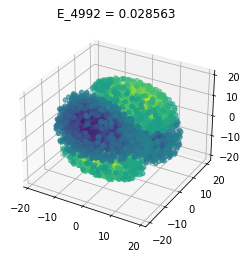

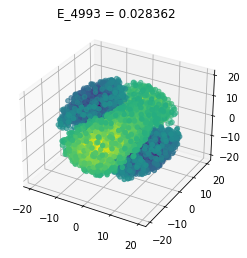

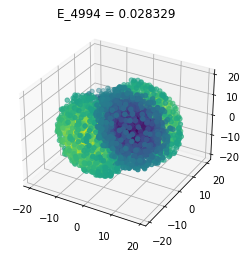

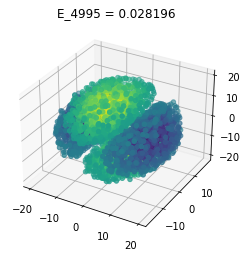

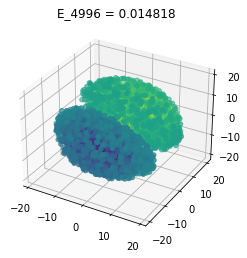

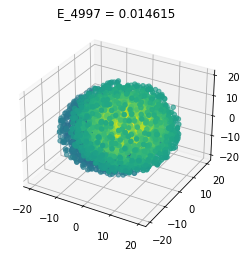

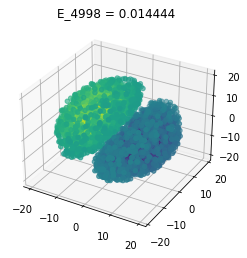

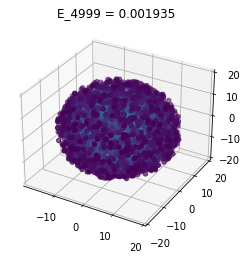

/tmp/ipykernel_1488431/4094258428.py:366: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10


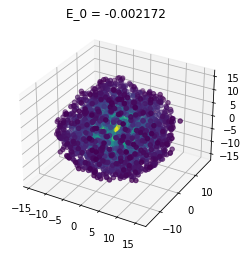

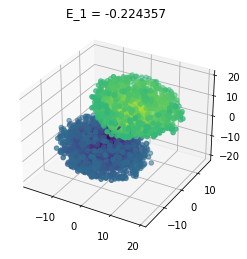

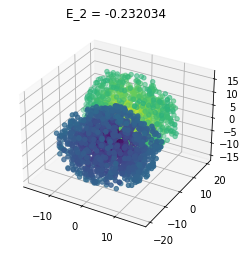

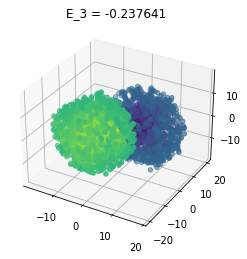

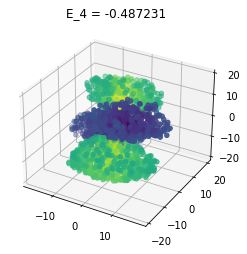

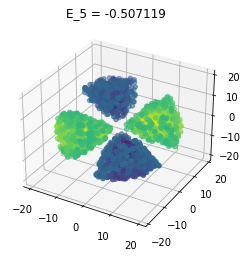

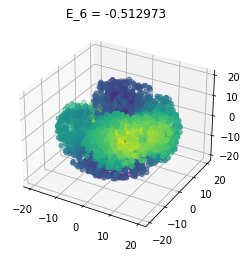

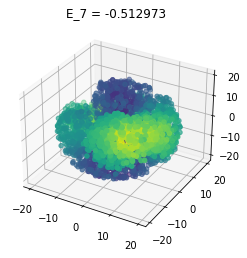

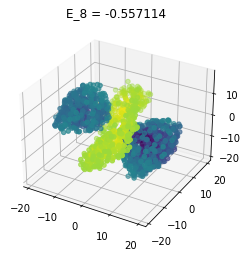

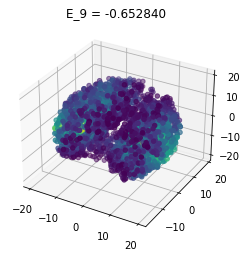

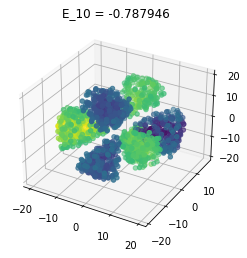

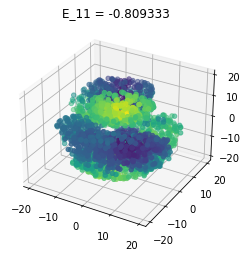

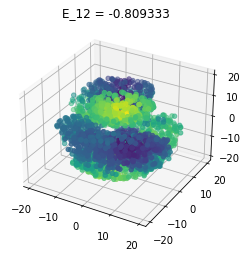

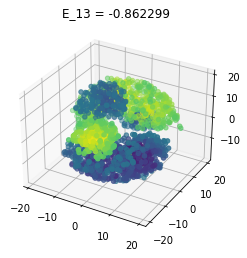

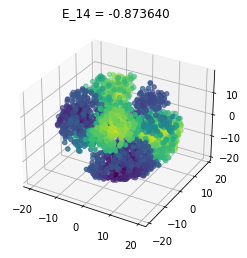

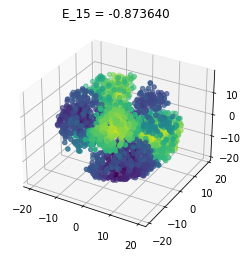

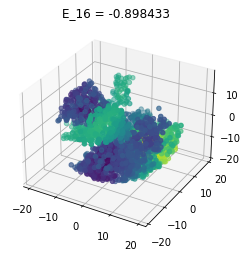

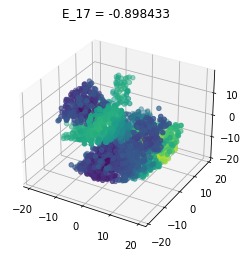

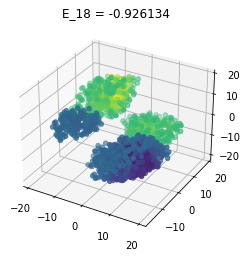

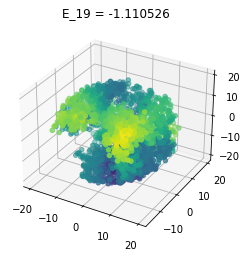

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # noqa: F401 unused import

from addPath import *
addPath()

from d3s import domain
from d3s import kernels
from d3s import algorithms
from d3s import systems
from d3s import observables

from d3s.tools import printVector, printMatrix

plt.ion()

#%% auxiliary functions
def gaussianG00G10(X, b, sigma, k):
    # Compute Gram matrices G_00 and G_10, assume sigma is fixed. Faster than standard implementation.
    if k.__class__.__name__ != 'gaussianKernel':
        print('Error: Only implemented for Gaussian kernel.')
        return
    m = X.shape[1]
    G_00 = kernels.gramian(X, k)
    G_10 = np.zeros((m, m))
    B = b(X).T @ X
    s = np.squeeze(sigma(X[:, 0, None]), 2)
    a = s @ s.T
    tra = np.trace(a)
    for i in range(m):
        for j in range(m):
            G_10[i, j] = -1/k.sigma**2 * (B[i, i] - B[i, j]) \
                        + 0.5*(1/k.sigma**4 * np.dot(X[:, i]-X[:, j], a @ (X[:, i]-X[:, j])) - 1/k.sigma**2 * tra )
    G_10 = G_10 * G_00
    return (G_00, G_10)

#%% Ornstein-Uhlenbeck process --------------------------------------------------------------------

#%% define domain
bounds = np.array([[-2, 2]])
boxes = np.array([100])
Omega = domain.discretization(bounds, boxes)

#%% define system
alpha = 1
beta = 4

def b(x):
    return -alpha*x

def sigma(x):
    return np.sqrt(2/beta)*np.ones((1, 1, x.shape[1]))

#%% generate data
m = 1000
X = Omega.rand(m)
Y = b(X)
Z = sigma(X)

# define kernel
#k = kernels.polynomialKernel(7)
k = kernels.gaussianKernel(0.5)

#%% apply kernel generator EDMD
epsilon = 0.1
S = np.einsum('ijk,ljk->ilk', Z, Z) # sigma \cdot sigma^T

G_00 = kernels.gramian(X, k)
G_10 = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        G_10[i, j] = Y[:, i].T @ k.diff(X[:, i], X[:, j]) + 0.5*np.sum( S[:, :, i] * k.ddiff(X[:, i], X[:, j]), axis=(0,1) )

A, _, _, _ = np.linalg.lstsq(G_00, G_10, rcond=1e-12)
d, V = algorithms.sortEig(A, evs=m, which='LM')
W = kernels.gramian2(Omega.midpointGrid(), X, k) @ V

#%% plot eigenvalues
plt.figure()
plt.plot(d, '.')
plt.title('Spectrum')

#%% plot eigenfunctions
ind, = np.where(d < -0.1)
for i in ind[:6]:
    plt.figure()
    Omega.plot(np.real(W[:, i]/np.amax(abs(W[:, i]))))
    plt.ylim((-1, 1))
    plt.title('lambda = %f' % np.real(d[i]))

#%% direct kernelization for kernels with finite-dimensional feature space
psi = observables.monomials(5)
PsiX = psi(X)
dPsiY = np.einsum('ijk,jk->ik', psi.diff(X), Y)
if not (Z is None): # stochastic dynamical system
    n = PsiX.shape[0] # number of basis functions
    ddPsiX = psi.ddiff(X) # second-order derivatives
    S = np.einsum('ijk,ljk->ilk', Z, Z) # sigma \cdot sigma^T
    for i in range(n):
        dPsiY[i, :] += 0.5*np.sum( ddPsiX[i, :, :, :] * S, axis=(0,1) )

G_00 = PsiX.T @ PsiX
G_10 = dPsiY.T @ PsiX

A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10
d, V = algorithms.sortEig(A, evs=m, which='SM')
V = G_00 @ V

plt.figure()
plt.plot(np.real(d), '.')

for i in range(m-6, m):
    plt.figure()
    plt.scatter(X, np.real(V[:, i]/np.amax(abs(V[:, i]))))
    plt.title('%f' % np.real(d[i]))

#%% reversible formulation (only first one or two eigenvalues are estimated accurately)
m  = 2000
f = systems.OrnsteinUhlenbeck(1e-3, 1000)
X = f.getTrajectory(np.zeros((1, 1)), m)
Z = sigma(X)

plt.figure()
plt.hist(X.T, 50)

G_00 = kernels.gramian(X, k)
G_h0 = np.zeros((m, m))
for i in range(m):
    if np.mod(i, 100) == 0:
        print(i)
    for j in range(m):
        G_h0[i, j] = Z[:, :, i] * k.diff(X[:, i], X[:, j])[0]

A, _, _, _ = np.linalg.lstsq(G_00 @ G_00, -0.5*G_h0.T @ G_h0, rcond=1e-12)

d, V = algorithms.sortEig(A, evs=m, which='SM')
V = G_00 @ V

plt.figure()
plt.plot(np.real(d), '.')

ind, = np.where(abs(d) > 0.1)
for i in ind[:5]:
    plt.figure()
    plt.scatter(X, np.real(V[:, i]/np.amax(abs(V[:, i]))))
    plt.title('%f' % d[i])


#%% Unsymmetric quadruple-well potential ----------------------------------------------------------------------

#%% define domain
bounds = np.array([[-2, 2], [-2, 2]])
boxes = np.array([30, 30])
Omega = domain.discretization(bounds, boxes)

#%% define system
def b(x):
    return np.vstack((-4*x[0, :]**3 + (3.0/16.0)*x[0, :]**2 + 4*x[0, :] - 3.0/16.0, \
                      -4*x[1, :]**3 + (3.0/8.0) *x[1, :]**2 + 4*x[1, :] - 3.0/8.0))

def sigma(x):
    n = x.shape[1]
    y = np.zeros((2, 2, n))
    y[0, 0, :] = 0.7
    y[1, 1, :] = 0.7
    return y

#%% define kernel
k = kernels.gaussianKernel(0.2)

#%% generate data
X = Omega.rand(1000)
Y = b(X)
Z = sigma(X)
m = X.shape[1]

#%% apply kernel generator EDMD
G_00, G_10 = gaussianG00G10(X, b, sigma, k)

epsilon = 0
A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10
# A, _, _, _ = np.linalg.lstsq(G_00, G_10, rcond=1e-12)
d, V = algorithms.sortEig(A, evs=m, which='SM')
W = kernels.gramian2(Omega.midpointGrid(), X, k) @ V

#%% plot eigenvalues
printVector(np.real(d[:10]), 'd')
plt.figure()
plt.plot(np.real(d), '.')

#%% plot eigenfunctions
ind, = np.where(d < -0.001)
for i in ind[:5]:
    plt.figure()
    plt.clf()
    #plt.scatter(X[0, :], X[1, :], c=V[:, i])
    Omega.plot(np.real(W[:, i]), '3D')
    plt.title('%f' % d[i])


#%% Quantum harmonic oscillator -------------------------------------------------------------------

#%% define domain
bounds = np.array([[-5, 5]])
boxes = np.array([100])
Omega = domain.discretization(bounds, boxes)

#%% define system
h  = 1
m0 = 1
omega = 1

def c0(x):
    return m0*omega**2*x**2/2

def c2(x):
    return -h**2/(2*m0)

#%% generate data
m = 100
X = Omega.rand(m)

#%% define kernel
k = kernels.gaussianKernel(1)

#%% apply kernel generator EDMD
G_00 = kernels.gramian(X, k)
G_10 = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        G_10[i, j] = c0(X[:, i]) * k(X[:, i], X[:, j]) + np.sum( c2(X[:, i]) * k.ddiff(X[:, i], X[:, j]), axis=(0,1) )

A, _, _, _ = np.linalg.lstsq(G_00, G_10, rcond=1e-12)
d, V = algorithms.sortEig(A, evs=m, which='LM')
W = kernels.gramian2(Omega.midpointGrid(), X, k) @ V

#%% plot spectrum
plt.figure(figsize=(4, 3))
plt.plot(d, '.')
plt.title('Spectrum')

#%% plot eigenfunctions
ind, = np.where(abs(d) > 0.1)
for i in ind[-6:]:
    plt.figure(figsize=(4, 3))
    Omega.plot(np.real(W[:, i]/np.amax(abs(W[:, i]))))
    plt.ylim((-1, 1))
    plt.title('lambda = %f' % d[i])

#%% analytical solution
def H_n(x, n):
    coef = np.zeros((n+1,))
    coef[n] = 1 
    return 1/np.sqrt(2**n*np.math.factorial(n)) * (m0*omega/(np.pi*h))**(1/4) * np.polynomial.hermite.hermval(np.sqrt(m0*omega/h)*x, coef)*np.exp(-m0*omega/(2*h)*x**2)

#%% compare solutions
x = Omega.midpointGrid()
for i in range(8):
    di = h*omega*(i+0.5)
    ind, = np.where(abs(d - di) < 0.1) # find corresponding eigenvalue
    xia = H_n(x[0, :], i)
    xi = np.real(W[:, ind]/np.amax(abs(W[:, ind])))*np.amax(abs(xia))
    plt.figure()
    Omega.plot(xia)
    Omega.plot(xi)
    plt.title('lambda = %f' % np.real(d[ind]))


#%% Hydrogen atom ---------------------------------------------------------------------------------

#%% define domain
bounds = np.array([[-20, 20], [-20, 20], [-20, 20]])
boxes = np.array([20, 20, 20])
Omega = domain.discretization(bounds, boxes)

#%% define system
h = 1 # reduced Planck constant 
e = 1 # charge of single electron
m0 = 1 # mass
eps0 = 1 # permittivity

def c0(x):
    r = np.linalg.norm(x)
    return -e**2/(4*np.pi*eps0*r)

def c2(x):
    return -h**2/(2*m0)*np.eye(3)

#%% define kernel
k = kernels.gaussianKernel(2)

#%% generate data (sample uniformly from the unit ball with radius 20)
m = 5000
X = np.random.randn(3, m)
r = 20*np.random.rand(m)**(1/3)
for i in range(m):
    X[:, i] = r[i]*X[:, i]/np.linalg.norm(X[:, i])

#%% apply kernel generator EDMD
epsilon = 0.0001
# evs = 10 # number of eigenfunctions to be computed

G_00 = kernels.gramian(X, k)
G_10 = np.zeros((m, m))
for i in range(m):
    if np.mod(i, 100) == 0:
        print(i)
    for j in range(m):
        #G_10[i, j] = c0(X[:, i]) * k(X[:, i], X[:, j]) + np.sum( c2(X[:, i]) * k.ddiff(X[:, i], X[:, j]), axis=(0,1) )
        G_10[i, j] = c0(X[:, i]) * k(X[:, i], X[:, j]) - h**2/(2*m0) * k.laplace(X[:, i], X[:, j])

A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10
d, V = algorithms.sortEig(A, evs=m, which='LM')
W = G_00 @ V

#%% plot spectrum
plt.figure(1); plt.clf()
plt.plot(np.real(d), '.')
plt.title('Spectrum')

#%% visualize eigenfunctions
for i in range(m-10, m):
    fig = plt.figure(2)
    plt.clf()
    ax = fig.add_subplot(111, projection='3d')
    w = W[:, i]/np.amax(abs(W[:, i]))
    ind, = np.where(abs(w) > 0.1)
    ax.scatter(X[0, ind], X[1, ind], X[2, ind], c=w[ind])
    plt.title('E_%i = %f' % (i, np.real(d[i])))
    plt.pause(1)

#%% apply kernel generator EDMD to corresponding Kolmogorov backward equation ---------------------

#%% change kernel bandwidth
k.sigma = 2

#%% generate data (sample uniformly from the unit ball with radius 20)
m = 5000
X = np.random.randn(3, m)
r = 20*np.random.rand(m)**(1/3)
for i in range(m):
    X[:, i] = r[i]*X[:, i]/np.linalg.norm(X[:, i])

#%% define system
a0 = (4*np.pi*eps0*h**2)/(m0*e**2) 
def b(x):
    nx = np.sqrt(x[0, :]**2 + x[1, :]**2 + x[2, :]**2)
    return -h**2/(a0*m0) * x @ np.diag(nx)

def sigma(x):
    n = x.shape[1]
    y = np.zeros((3, 3, n))
    y[0, 0, :] = 1
    y[1, 1, :] = 1
    y[2, 2, :] = 1
    return y

#%% apply kernel generator EDMD
G_00, G_10 = gaussianG00G10(X, b, sigma, k)

epsilon = 0
A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10
# A, _, _, _ = np.linalg.lstsq(G_00, G_10, rcond=1e-12)
d, V = algorithms.sortEig(A, evs=m, which='SR')

# c = Omega.midpointGrid()
# W = kernels.gramian2(c, X, k) @ V
W = G_00 @ V

#%% ground state (not normalized)
h = 1 # reduced Planck constant 
e = 1 # charge of single electron
m0 = 1 # mass
eps0 = 1 # permittivity

a0 = (4*np.pi*eps0*h**2)/(m0*e**2)
def psi_0(x):
    return np.exp(-1/a0 * np.sqrt(x[0, :]**2 + x[1, :]**2 + x[2, :]**2))

#%% visualize eigenfunctions
#psi = psi_0(c)
psi = psi_0(X)
for i in range(20):
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111, projection='3d')
    w = W[:, i] * psi
    w = w/np.amax(abs(w))
    ind, = np.where(abs(w) > 0.3)
    #ax.scatter(c[0, ind], c[1, ind], c[2, ind], c=w[ind])
    ax.scatter(X[0, ind], X[1, ind], X[2, ind], c=w[ind])
    plt.title('E_%i = %f' % (i, np.real(d[i])))
